# Set Initial Parameters
---

In [1]:
import pyspark
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("spark")\
.config('spark.driver.memory', '48g')\
.config("hive.server2.thrift.port", 10000)\
.config("spark.sql.hive.thriftServer.singleSession", True)\
.config("spark.driver.maxResultSize", "10g")\
.enableHiveSupport()\
.getOrCreate()

22/04/25 19:19:17 WARN Utils: Your hostname, Ewins-Mac-Hex.local resolves to a loopback address: 127.0.0.1; using 192.168.0.47 instead (on interface en0)
22/04/25 19:19:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/04/25 19:19:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
mode = "full"

# Initialization
---

### Loading the required Libraries for Time-Series Analysis

In [3]:
%pip install FBProphet

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
import logging
logging.getLogger('py4j').setLevel(logging.ERROR)

### Loading the data

In [6]:
df1 = spark.read.format('parquet').load("/Users/minoseah629/Repos/AIT614Project/ewin/spark-warehouse/ait614projectpermanenttable")

In [8]:
df1.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Speed: double (nullable = true)
 |-- TravelTime: integer (nullable = true)
 |-- Status: integer (nullable = true)
 |-- timedate: timestamp (nullable = true)
 |-- LinkId: integer (nullable = true)
 |-- LinkPoints: string (nullable = true)
 |-- EncodedLinkPoints: string (nullable = true)
 |-- EncodedPolyLineLvls: string (nullable = true)
 |-- Owner: string (nullable = true)
 |-- TranscomId: integer (nullable = true)
 |-- Borough: string (nullable = true)
 |-- Link_Name: string (nullable = true)



In [9]:
df1 = df1.withColumnRenamed("Speed", "speed")
df1 = df1.withColumnRenamed("timedate", "ds")
df1 = df1.withColumnRenamed("LinkId", "link_id")


In [10]:
from pyspark.sql.types import StringType
df1 = df1.withColumn("link_id",df1.link_id.cast('string'))

In [14]:
df = df1.select('ds', 'link_id', 'speed')

In [15]:
# Filtering records within 2018 to 2021
df = df.filter(df.ds >= '2018-01-01')
df = df.filter(df.ds < '2022-01-01')

In [16]:
df.cache()
df.printSchema()
df.show(10)

root
 |-- ds: timestamp (nullable = true)
 |-- link_id: string (nullable = true)
 |-- speed: double (nullable = true)



+-------------------+-------+-----+
|                 ds|link_id|speed|
+-------------------+-------+-----+
|2021-12-07 17:58:03|4329507|16.77|
|2021-12-07 17:58:03|4362244|45.98|
|2021-12-07 17:58:03|4362247|41.63|
|2021-12-07 17:58:03|4362249|24.85|
|2021-12-07 17:58:03|4362250|49.08|
|2021-12-07 17:58:03|4362251|27.34|
|2021-12-07 17:58:03|4362252|38.52|
|2021-12-07 17:58:03|4362314|40.38|
|2021-12-07 17:58:03|4362342| 9.32|
|2021-12-07 17:58:03|4456479|39.14|
+-------------------+-------+-----+
only showing top 10 rows



In [17]:
df.createOrReplaceTempView('data')

# Time-Seriers Analysis | Entire Dataset
---

## Training Time-Series Model

In [18]:
# Filtering data from 2018 to June 2021 as training set. Reducing the training set any further will directly impact the model accuracy, due to fluctuations in 2020 data during COVID-19 pandemic.

train = '''
SELECT ds, AVG(speed) AS y
FROM data
GROUP BY ds
ORDER BY ds;
'''

df_train = spark.sql(train).toPandas()

In [19]:
# Training the prophet model on the training set
from fbprophet import Prophet

ts_model = Prophet(
    interval_width=0.9,
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False
)

ts_model.fit( df_train )

/Users/minoseah629/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -31241.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Error evaluating model log probability: Non-finite gradient.
Error evaluating model log probability: Non-finite gradient.

      99    3.5651e+06    0.00142359       52638.2       0.554       0.554      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199   3.56711e+06      0.010143       21208.3           1           1      236   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299   3.56949e+06      0.011928       61752.5           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
   

In [21]:
# Predicting future for 'fut' more days

fut = 365*24*2
df_future = ts_model.make_future_dataframe(
    periods=fut,
    freq='H',
    include_history=True
)

# predict over the dataset
df_forecast = ts_model.predict(df_future)

display(df_forecast)

/Users/minoseah629/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/minoseah629/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01 00:02:09,32.085500,15.287052,56.198385,32.085500,32.085500,3.235958,3.235958,3.235958,2.513521,2.513521,2.513521,0.722437,0.722437,0.722437,0.0,0.0,0.0,35.321457
1,2018-01-01 00:02:10,32.085500,14.670893,55.652283,32.085500,32.085500,3.235767,3.235767,3.235767,2.513353,2.513353,2.513353,0.722414,0.722414,0.722414,0.0,0.0,0.0,35.321266
2,2018-01-01 00:02:12,32.085499,14.384203,55.282390,32.085499,32.085499,3.235386,3.235386,3.235386,2.513017,2.513017,2.513017,0.722368,0.722368,0.722368,0.0,0.0,0.0,35.320885
3,2018-01-01 00:02:13,32.085499,14.066737,56.524550,32.085499,32.085499,3.235195,3.235195,3.235195,2.512850,2.512850,2.512850,0.722346,0.722346,0.722346,0.0,0.0,0.0,35.320694
4,2018-01-01 00:02:17,32.085498,13.081505,53.838910,32.085498,32.085498,3.234433,3.234433,3.234433,2.512179,2.512179,2.512179,0.722255,0.722255,0.722255,0.0,0.0,0.0,35.319932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2551772,2023-12-31 19:59:13,34.163111,-203.246586,288.317246,-200.645049,287.763001,-0.046521,-0.046521,-0.046521,-1.113548,-1.113548,-1.113548,1.067027,1.067027,1.067027,0.0,0.0,0.0,34.116591
2551773,2023-12-31 20:59:13,34.163196,-194.967030,285.122997,-200.663062,287.785665,2.315267,2.315267,2.315267,1.334886,1.334886,1.334886,0.980381,0.980381,0.980381,0.0,0.0,0.0,36.478463
2551774,2023-12-31 21:59:13,34.163280,-198.040813,294.766867,-200.681075,287.808330,3.716834,3.716834,3.716834,2.822501,2.822501,2.822501,0.894333,0.894333,0.894333,0.0,0.0,0.0,37.880114
2551775,2023-12-31 22:59:13,34.163365,-196.130005,295.755383,-200.699088,287.830994,3.879135,3.879135,3.879135,3.069641,3.069641,3.069641,0.809494,0.809494,0.809494,0.0,0.0,0.0,38.042500


In [22]:
df_forecast.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2551772,2023-12-31 19:59:13,34.163111,-203.246586,288.317246,-200.645049,287.763001,-0.046521,-0.046521,-0.046521,-1.113548,-1.113548,-1.113548,1.067027,1.067027,1.067027,0.0,0.0,0.0,34.116591
2551773,2023-12-31 20:59:13,34.163196,-194.967030,285.122997,-200.663062,287.785665,2.315267,2.315267,2.315267,1.334886,1.334886,1.334886,0.980381,0.980381,0.980381,0.0,0.0,0.0,36.478463
2551774,2023-12-31 21:59:13,34.163280,-198.040813,294.766867,-200.681075,287.808330,3.716834,3.716834,3.716834,2.822501,2.822501,2.822501,0.894333,0.894333,0.894333,0.0,0.0,0.0,37.880114
2551775,2023-12-31 22:59:13,34.163365,-196.130005,295.755383,-200.699088,287.830994,3.879135,3.879135,3.879135,3.069641,3.069641,3.069641,0.809494,0.809494,0.809494,0.0,0.0,0.0,38.042500
2551776,2023-12-31 23:59:13,34.163450,-194.780118,280.661194,-200.717101,287.853658,3.269737,3.269737,3.269737,2.543296,2.543296,2.543296,0.726442,0.726442,0.726442,0.0,0.0,0.0,37.433187


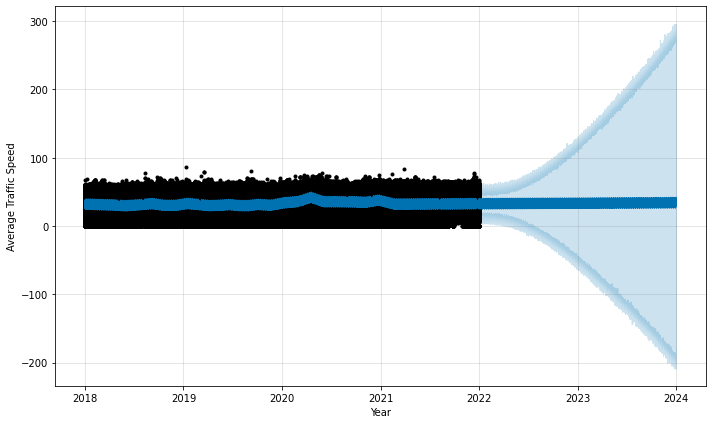

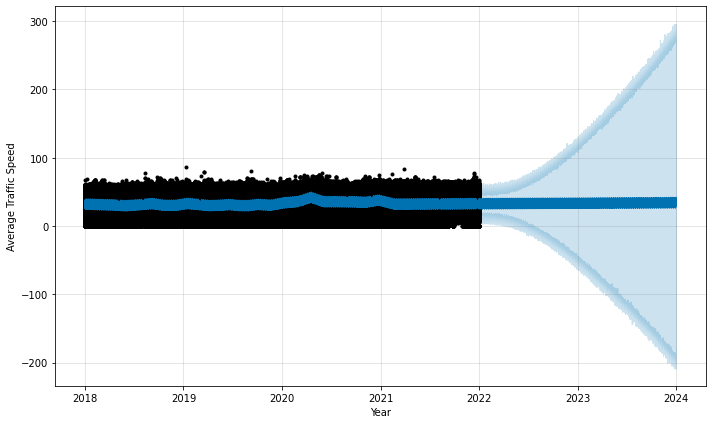

In [23]:
fig_trends = ts_model.plot(df_forecast, xlabel='Year', ylabel='Average Traffic Speed')
display(fig_trends)

/Users/minoseah629/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Users/minoseah629/Library/Python/3.8/lib/python/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


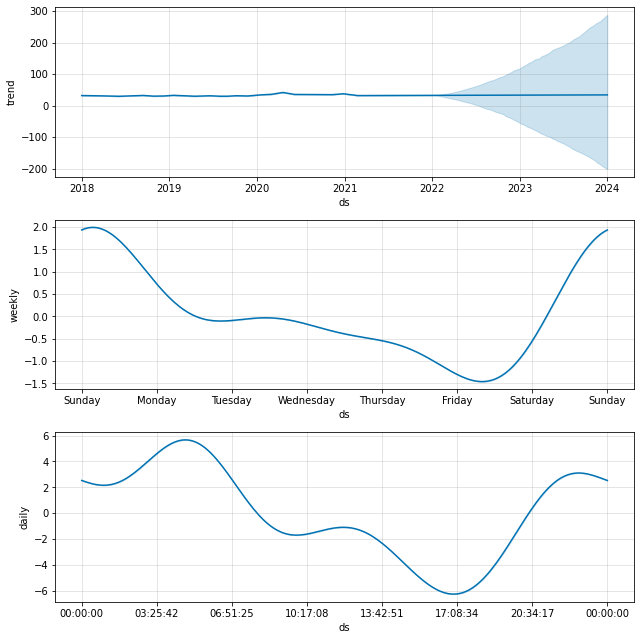

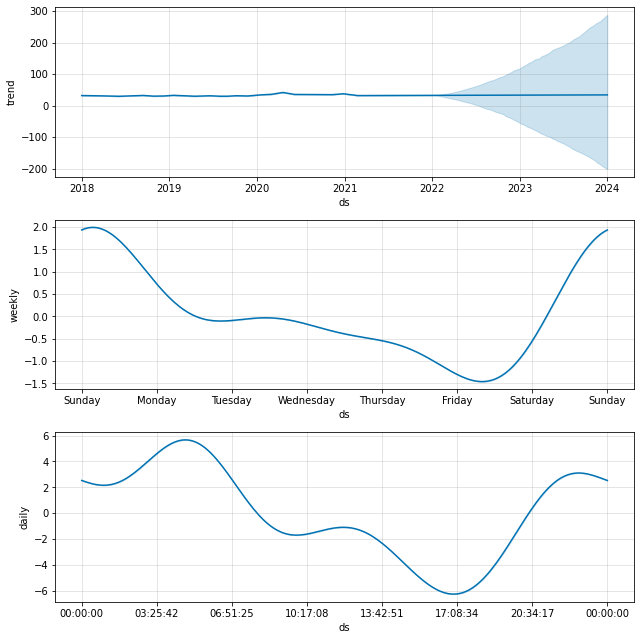

In [24]:
fig_components = ts_model.plot_components(df_forecast)
display(fig_components)